# Gibbs chain verification

In [600]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import healpy as hp
import astropy.io.fits as fits
import camb
import scipy
import toml
import jax
import jax.numpy as jnp
import jax.lax as jlax
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from fgbuster.observation_helpers import *
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [601]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')

In [602]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'main_params/'
directory_additional_params = working_directory_path + 'additional_params/'


# Studying the sampling !

In [603]:
sub_step_sampling = 1
num_jobs = 1
file_ver = 'class_fullsky_1freq_nofg_v1a2_{}_{}'
path_additional_params = directory_additional_params + 'add_class_fullsky_f1freq_nofg_v1a.toml'
## Test classical Gibbs

# sub_step_sampling = 1
# num_jobs = 1
# file_ver = 'class_cutsky_1freq_nofg_v1a5_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1a.toml'
# ## Test classical Gibbs

# # sub_step_sampling = 1
# # num_jobs = 4
# # file_ver = 'class_cutsky_1freq_nofg_v1b3_{}_{}'
# # path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1b.toml'
# # ## Test classical Gibbs with L_BB(r)

# sub_step_sampling = 1
# num_jobs = 1
# file_ver = 'class_cutsky_1freq_nofg_v1c_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1c.toml'
# # ## Binning was wrong

# sub_step_sampling = 50
# num_jobs = 1
# file_ver = 'class_cutsky_1freq_nofg_v1d_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1d.toml'
# # ## With save_s_c_spectra = True

# # sub_step_sampling = 1
# # num_jobs = 1
# # file_ver = 'class_cutsky_1freq_nofg_v1cc2_{}_{}'
# # path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1c.toml'
# # ##


# sub_step_sampling = 1
# num_jobs = 1
# file_ver = 'class_fullsky_noncentered_1freq_nofg_v2a_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v2a.toml'
# ## With non-centered moves for C

# sub_step_sampling = 1
# num_jobs = 1
# file_ver = 'class_cutsky_noncentered_1freq_nofg_v2a_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v2a.toml'
# # ## With non-centered moves for C

sub_step_sampling = 50
num_jobs = 1
file_ver = 'class_cutsky_1freq_nofg_v1db3_{}_{}'
path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1db.toml'
## High tol_CG and number of iterations

# sub_step_sampling = 50
# num_jobs = 4
# file_ver = 'class_fullsky_1freq_nofg_v1b_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_fullsky_f1freq_nofg_v1b.toml'
# ## 4 walkers test full sky -> Seem quite stable and ok on the value

# sub_step_sampling = 50
# num_jobs = 4
# file_ver = 'class_cutsky_noncentered_1freq_nofg_v2b_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v2c.toml'
# ## Non-centered test

# sub_step_sampling = 50
# num_jobs = 4
# file_ver = 'class_cutsky_binned_1freq_nofg_v1e3_{}_{}'
# path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1e.toml'
# ## Binning 4 walkers -> seems quite stable, but not to the right value

sub_step_sampling = 50
num_jobs = 4
file_ver = 'class_cutsky_1freq_nofg_v1h3_{}_{}'
path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1h.toml'
## Different CMB realization -> need to continue

sub_step_sampling = 50
num_jobs = 4
file_ver = 'class_cutsky_1freq_nofg_v1f3_{}_{}'
path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1f.toml'
## Different CMB realization -> need to continue

sub_step_sampling = 50
num_jobs = 4
file_ver = 'class_cutsky_1freq_nofg_v1g3_{}_{}'
path_additional_params = directory_additional_params + 'add_class_cutsky_f1freq_nofg_v1g.toml'
## 

In [604]:
fast_verion_bool = True

In [605]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()

directory_mask = dictionary_additional_parameters['directory_mask']
reduction_noise = dictionary_additional_parameters['reduction_noise']
# factor_Fisher = dictionary_additional_parameters['factor_Fisher']
# relative_treshold = dictionary_additional_parameters['relative_treshold']
# sigma_gap = dictionary_additional_parameters['sigma_gap']
fgs_model = dictionary_additional_parameters['fgs_model']
# initial_guess_r = dictionary_additional_parameters['initial_guess_r']
# use_nhits = dictionary_additional_parameters['use_nhits']
name_mask = dictionary_additional_parameters['name_mask']
# use_mask = dictionary_additional_parameters['use_mask']
name_toml = dictionary_additional_parameters['name_toml']
name_file_spv = dictionary_additional_parameters['name_file_spv']
print("Using toml file: ", name_toml)

Using toml file:  class_cutsky_1freq_v3.toml


In [606]:
path_toml_file = directory_toml_file + name_toml
if name_file_spv != '':
    path_file_spv = directory_toml_file + name_file_spv
else:
    path_file_spv = ''

In [607]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file, path_file_spv)

No spatial variability case

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [0]

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [0]


In [608]:
if (MICMAC_sampler_obj.number_iterations_sampling > 100) and (sub_step_sampling==1):
    sub_step_sampling = 50
elif MICMAC_sampler_obj.number_iterations_sampling > 1000:
    sub_step_sampling = 100
elif MICMAC_sampler_obj.number_iterations_sampling > 3000:
    sub_step_sampling = 200

In [609]:
NSIDE = MICMAC_sampler_obj.nside
noise_seed = MICMAC_sampler_obj.seed
instr_name = MICMAC_sampler_obj.instrument_name

# get instrument from public database
if MICMAC_sampler_obj.instrument_name != 'customized_instrument': ## TODO: Improve a bit this part
        instrument = get_instrument(MICMAC_sampler_obj.instrument_name)
else:
    with open(path_toml_file) as f:
        dictionary_toml = toml.load(f)
    f.close()
    instrument = micmac.get_instr(MICMAC_sampler_obj.frequency_array, dictionary_toml['depth_p'])

# get input freq maps
np.random.seed(noise_seed)

freq_maps_fgs = get_observation(instrument, fgs_model, nside=NSIDE, noise=True)[:, 1:, :]   # keep only Q and U


In [610]:
freq_inverse_noise = micmac.get_noise_covar_extended(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [611]:
_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


Calculating spectra from CAMB !


Calculating spectra from CAMB !


In [612]:
initial_freq_maps = []
input_cmb_maps = []
all_eta_maps = []
all_s_c_WF_maps = []
all_s_c_fluct_maps = []
all_s_c_samples = []
all_s_c_spectra = []
all_r_samples = []
all_cell_samples = []
all_params_mixing_matrix_samples = []

for job in range(num_jobs):

    initial_freq_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_data.npy'
    initial_freq_maps.append(np.load(initial_freq_maps_path))

    initial_cmb_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_cmb_data.npy'
    input_cmb_maps.append(np.load(initial_cmb_maps_path))
    if MICMAC_sampler_obj.save_eta_chain_maps:
        all_eta_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_eta_maps.npy'
        all_eta_maps.append(np.load(all_eta_maps_path))
    
    if MICMAC_sampler_obj.save_CMB_chain_maps:
        all_s_c_WF_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c_WF_maps.npy'
        all_s_c_WF_maps.append(np.load(all_s_c_WF_maps_path))

        all_s_c_fluct_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c_fluct_maps.npy'
        all_s_c_fluct_maps.append(np.load(all_s_c_fluct_maps_path))
    
    if MICMAC_sampler_obj.save_s_c_spectra:
        all_s_c_spectra_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c_spectra.npy'
        all_s_c_spectra.append(np.load(all_s_c_spectra_path))


    if MICMAC_sampler_obj.sample_r_Metropolis:
        all_r_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_r_samples.npy'
        all_r_samples.append(np.load(all_r_samples_path))
    elif MICMAC_sampler_obj.sample_C_inv_Wishart:
        all_cell_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_cell_samples.npy'
        all_cell_samples.append(np.load(all_cell_samples_path))

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_params_mixing_matrix_samples.npy'
    all_params_mixing_matrix_samples.append(np.load(all_params_mixing_matrix_samples_path))

initial_freq_maps = np.array(initial_freq_maps)
input_cmb_maps = np.array(input_cmb_maps)
if MICMAC_sampler_obj.save_eta_chain_maps:
    all_eta_maps = np.array(all_eta_maps)
if MICMAC_sampler_obj.save_CMB_chain_maps:
    all_s_c_WF_maps = np.array(all_s_c_WF_maps)
    all_s_c_fluct_maps = np.array(all_s_c_fluct_maps)
if MICMAC_sampler_obj.sample_r_Metropolis:
    all_r_samples = np.array(all_r_samples)
elif MICMAC_sampler_obj.sample_C_inv_Wishart:
    all_cell_samples = np.array(all_cell_samples)
if MICMAC_sampler_obj.save_s_c_spectra:
    all_s_c_spectra = np.array(all_s_c_spectra)
all_params_mixing_matrix_samples = np.array(all_params_mixing_matrix_samples)

In [613]:
print("### Expected", MICMAC_sampler_obj.number_iterations_sampling, "iterations, but got", all_params_mixing_matrix_samples.shape[1] - 1, "iterations !!!")
MICMAC_sampler_obj.number_iterations_sampling = all_params_mixing_matrix_samples.shape[1] - 1

### Expected 450 iterations, but got 1350 iterations !!!


In [614]:
assert MICMAC_sampler_obj.number_iterations_sampling + 1 == all_params_mixing_matrix_samples.shape[1]

In [615]:
path_Fisher = working_directory_path+'../Fisher_matrix_{}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'.format(MICMAC_sampler_obj.instrument_name)

try: 
    Fisher_matrix = np.loadtxt(path_Fisher)
    print(jnp.array(jnp.diag(jsp.linalg.sqrtm(np.linalg.inv(Fisher_matrix))), dtype=jnp.float64))
except:
    print("No Fisher matrix found at", path_Fisher)
    Fisher_matrix = None

No Fisher matrix found at /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Validation_Classical_Gibbs/../Fisher_matrix_customized_instrument_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt


In [616]:

# Getting C_approx and a first guess for C
c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]


# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), 
                                                 MICMAC_sampler_obj.n_components, 
                                                 pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, 
                                                 spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b)

if MICMAC_sampler_obj.n_components != 1:
    init_params = jnp.array(init_mixing_matrix_obj.init_params())
else:
    init_params = jnp.zeros(0)

# mixing_matrix_obj = micmac.MixingMatrix(frequency_array=instrument['frequency'], 
#                                         n_components=MICMAC_sampler_obj.n_components, 
#                                         params=init_params,
#                                         pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, 
#                                         spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b, 
#                                         nside=MICMAC_sampler_obj.nside)
MICMAC_sampler_obj.update_params(init_params)
mixing_matrix_sampled = MICMAC_sampler_obj.get_B()

len_pos_special_freqs = len(MICMAC_sampler_obj.pos_special_freqs)

# Noise initialization
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
# BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


In [617]:
n_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = n_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [618]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter

## Handling mask

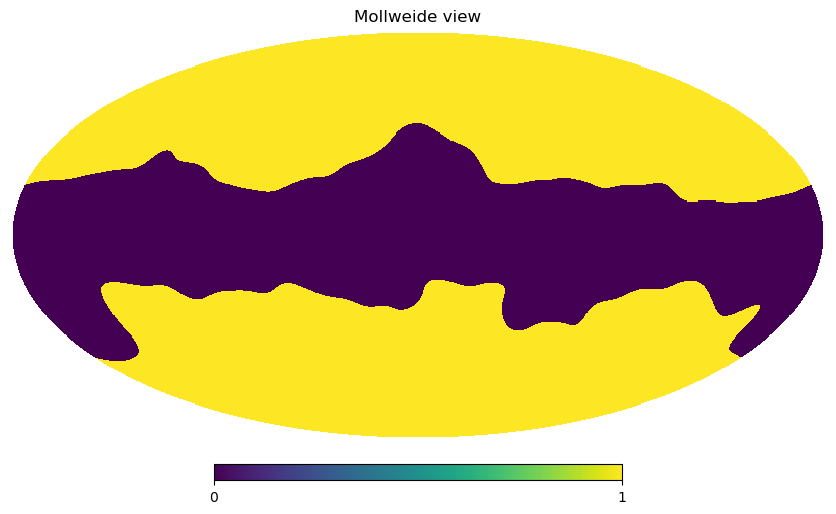

In [619]:
directory_mask_local = '/Users/mag/Documents/PHD1Y/masks/'
path_mask = directory_mask_local + name_mask + '.fits'

if os.path.exists(path_mask):
    mask = hp.read_map(path_mask, verbose=False)

    hp.mollview(mask)

    mask = np.int64(hp.ud_grade(mask, nside_out=MICMAC_sampler_obj.nside, dtype=np.float64))

    MICMAC_sampler_obj.mask = mask

    if MICMAC_sampler_obj.indexes_b.size != 1: 
    # if MICMAC_sampler_obj.size_patches.max() > 1:
        frequency_Bf = np.array(instrument['frequency'][1:-1])
        number_free_Bf = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*(MICMAC_sampler_obj.n_components - 1)
        extended_array = np.zeros((number_free_Bf+1),dtype=np.int64)
        extended_array[:-1] = MICMAC_sampler_obj.indexes_b.ravel(order='F')
        extended_array[-1] = extended_array[:-1].max() + MICMAC_sampler_obj.size_patches[-1]
        
        all_templates = MICMAC_sampler_obj.get_all_templates()%MICMAC_sampler_obj.size_patches[-1] + 1
        # for i in range(number_free_Bf):
        #     freq = i//(MICMAC_sampler_obj.n_components - 1)
        #     comp = i%(MICMAC_sampler_obj.n_components - 1)
        hp.mollview(all_templates[0,0] - all_templates[0,0]*mask)
    plt.show()

## Testing $\eta$

In [620]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

In [621]:
all_params_mixing_matrix_samples.shape

(4, 1351, 1)

In [622]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

red_cl_noise_harm = np.zeros_like(red_cov_approx_matrix)
if MICMAC_sampler_obj.save_eta_chain_maps:
    for job in range(num_jobs):
        for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
            mixing_matrix_sampled = MICMAC_sampler_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            # BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

            cl_noise = BtinvNB[0,0].mean()*hp.nside2resol(MICMAC_sampler_obj.nside)**2
            red_cl_noise_harm[:] = np.diag([cl_noise,cl_noise])
            full_cl_noise = np.zeros_like(c_ell_approx)
            full_cl_noise[:MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.lmin:] = cl_noise.mean()

            # analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_personalized/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
            analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)

            # analytical_eta_term = np.zeros_like(c_ell_approx)
            analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]

            eta_maps_extended = np.vstack([np.zeros_like(all_eta_maps[job,iteration,0,...]), all_eta_maps[job,iteration]])
            c_ells_eta = hp.anafast(eta_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            plt.figure(figsize=(7,5))
            plt.suptitle(r"Comparison $\eta$ CG vs theoretical for iteration {}".format(iteration))

            for j in range(n_correl_to_plot):
                ax = plt.subplot(311+j)
                plt.title(list_correl[j])
                
                plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')

                plt.plot(ell_arange, c_ell_approx[j,MICMAC_sampler_obj.lmin:], label='c_ell_approx')
                # plt.plot(ell_arange, full_cl_noise[j,MICMAC_sampler_obj.lmin:], label='c_ell N_c')
                plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")

                plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

                if MICMAC_sampler_obj.nstokes == 3 and j < n_correl_to_plot-2:
                    plt.xticks(color='w')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                    # plt.ylim(ymin=noise_level/10.)
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                # plt.legend()
                if j == position_legend:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
                
                plt.ylabel("$C_\ell$ [$uK^2$]")
                if j == n_correl_to_plot-1:
                    plt.xlabel(r"$\ell$")
        plt.show()

# Validation $s_c$

In [623]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if MICMAC_sampler_obj.save_CMB_chain_maps:
    for job in range(num_jobs):
        for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            
            if MICMAC_sampler_obj.sample_r_Metropolis:
                red_cov_matrix = theoretical_red_cov_r0_total + all_r_samples[job,iteration]*theoretical_red_cov_r1_tensor
            elif MICMAC_sampler_obj.sample_C_inv_Wishart:
                red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[job,iteration,...])#[MICMAC_sampler_obj.lmin:]
                if iteration != 0:
                    red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[job,iteration-1,...])#[MICMAC_sampler_obj.lmin:]
            if MICMAC_sampler_obj.n_components != 1:
                MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
                if iteration != 0:
                    MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[job,iteration-1])
            mixing_matrix_sampled = MICMAC_sampler_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            # BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
            s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps[job], jax_use=False)[0, :, :]


            _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
            red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
            cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

            analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
            # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
            analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                                analytical_WF_harm, lmin=lmin, n_iter=n_iter)


            full_map_s_c = all_s_c_WF_maps[job,iteration] + all_s_c_fluct_maps[job,iteration]
            full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
            c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
            # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
            # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

            analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
            analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
            analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

            s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[job,iteration,0,...]), all_s_c_WF_maps[job,iteration]])
            c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[job,iteration,0,...]), all_s_c_fluct_maps[job,iteration]])
            c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
            s_c_recovered = all_s_c_WF_maps[job,iteration,...] + all_s_c_fluct_maps[job,iteration,...]
            s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
            c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            plt.figure(figsize=(14,8))
            plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

            for j in range(n_correl_to_plot):
                plt.subplot(331+3*j)
                plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, analytical_WF_cells[j,:], label='Analytical WF')
                plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.title('WF term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")
                plt.xlabel(r"$\ell$")
                plt.legend()

                plt.subplot(332+3*j)
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.title('Fluctuation term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")
                plt.xlabel(r"$\ell$")
                plt.legend()
                
                plt.subplot(333+3*j)
                plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
                plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")

                plt.xlabel(r"$\ell$")
                plt.legend()
        plt.show()

In [624]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if MICMAC_sampler_obj.save_CMB_chain_maps:
    for job in range(num_jobs):
        for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            if MICMAC_sampler_obj.n_components != 1:
                MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
                if iteration != 0:
                    MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[job,iteration-1])
            mixing_matrix_sampled = MICMAC_sampler_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
            s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps[job], jax_use=False)[0, :, :]


            _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
            red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
            cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

            full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
            c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            s_c_recovered = all_s_c_WF_maps[job,iteration,...] + all_s_c_fluct_maps[job,iteration,...]
            # s_c_recovered = all_s_c_samples[iteration,...]
            s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
            c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

            plt.figure(figsize=(10,5))
            plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

            for j in range(n_correl_to_plot):
                plt.subplot(311+j)
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
                plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

                if j <= MICMAC_sampler_obj.nstokes-1:
                    plt.loglog()
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                else:
                    plt.xscale('log')
                    plt.yscale('symlog')
                    plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
                plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
                plt.ylabel("$C_\ell$ [$uK^2$]")
                
                plt.xlabel(r"$\ell$")
                


        plt.show()

In [625]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

if not(fast_verion_bool):
    for job in range(num_jobs):
        plt.figure(figsize=(14,8))
        for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
            covariance_noise = np.zeros_like(c_ell_approx)

            # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[MICMAC_sampler_obj.lmin:]
            MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
            if iteration != 0:
                # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])[MICMAC_sampler_obj.lmin:]
                MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[job,iteration-1])
            mixing_matrix_sampled = MICMAC_sampler_obj.get_B()
            BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
            # BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
            BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
            s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps[job], jax_use=False)[0, :, :]

            # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
            full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
            c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

            plt.plot(np.arange(c_ell_s_cML.shape[-1])+lmin, c_ell_s_cML[1,:], 'g', alpha=.5)

        plt.title(f"Full $s_c$ term - {list_correl[1]} for job {job} over {num_jobs}")
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.loglog()
        plt.legend()


    plt.show()

# Studying $s_c$ spectra

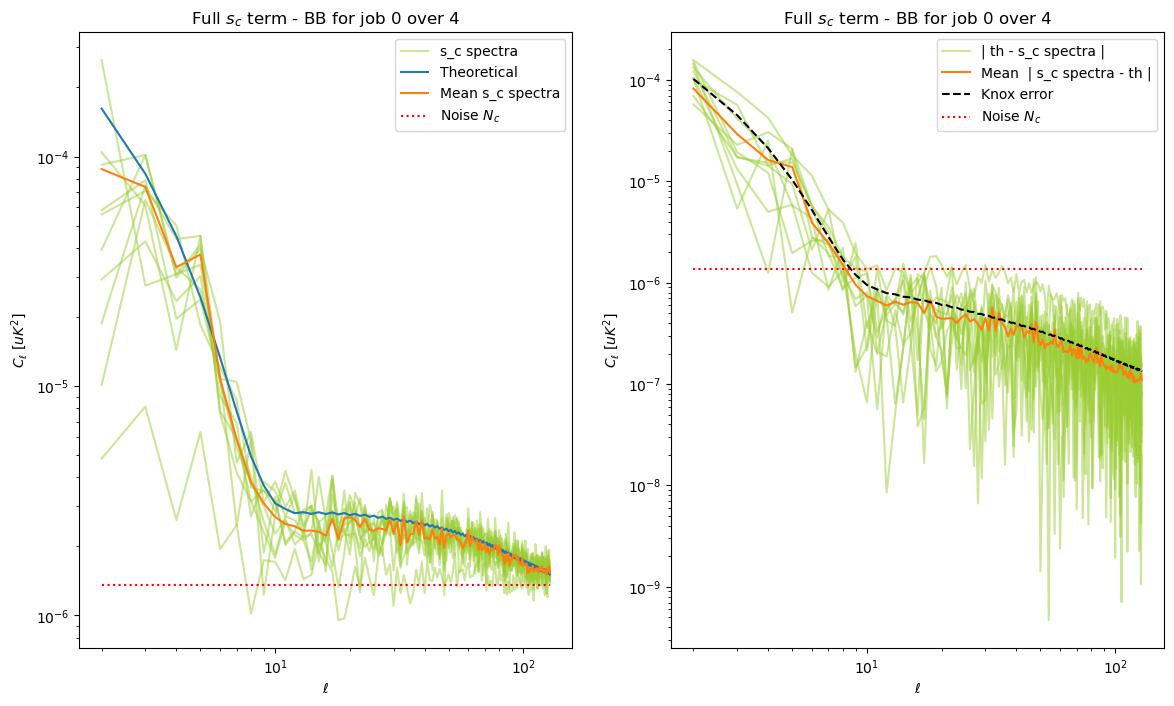

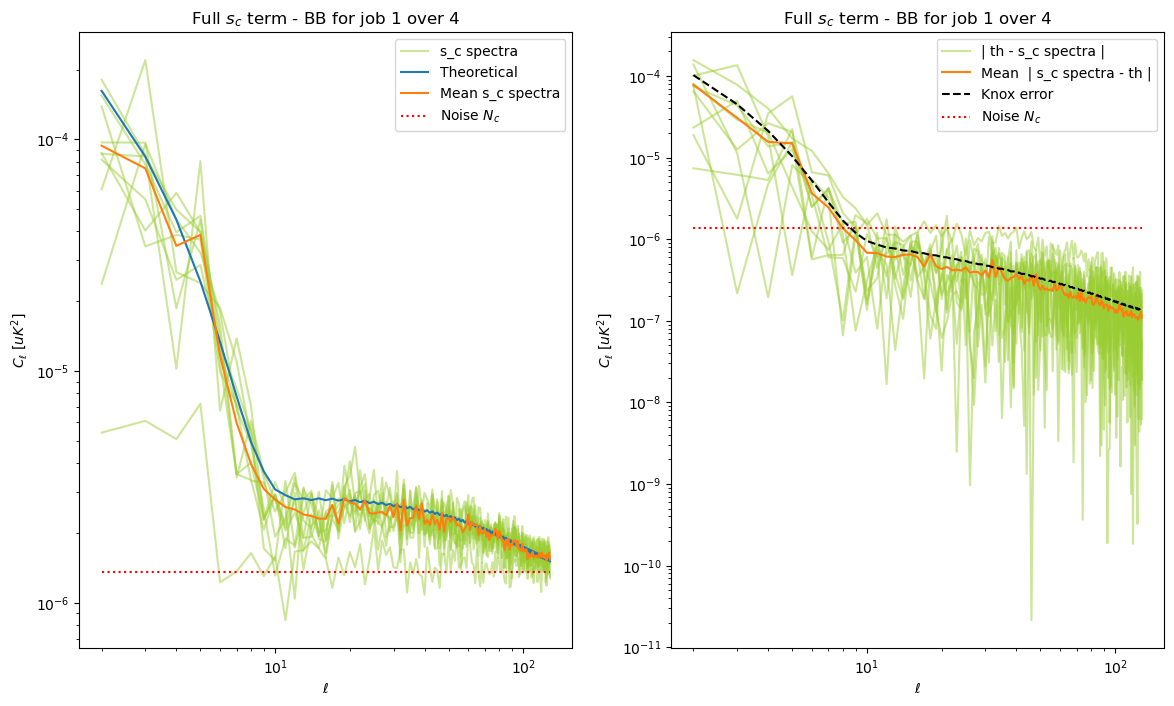

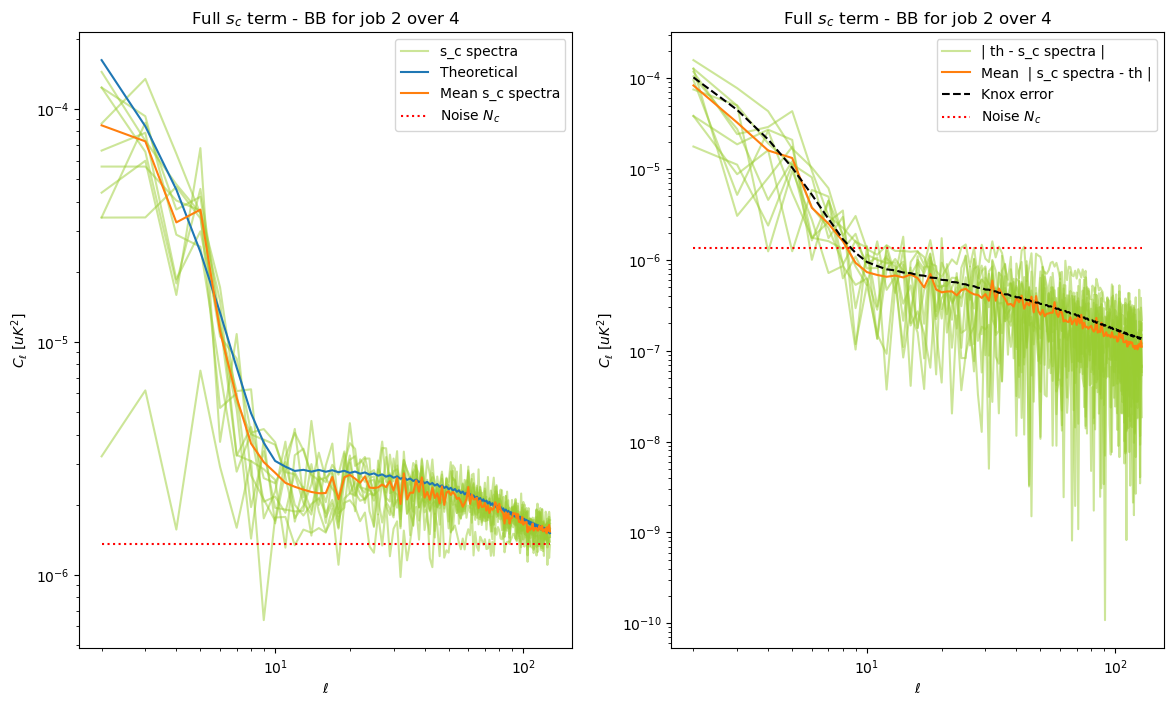

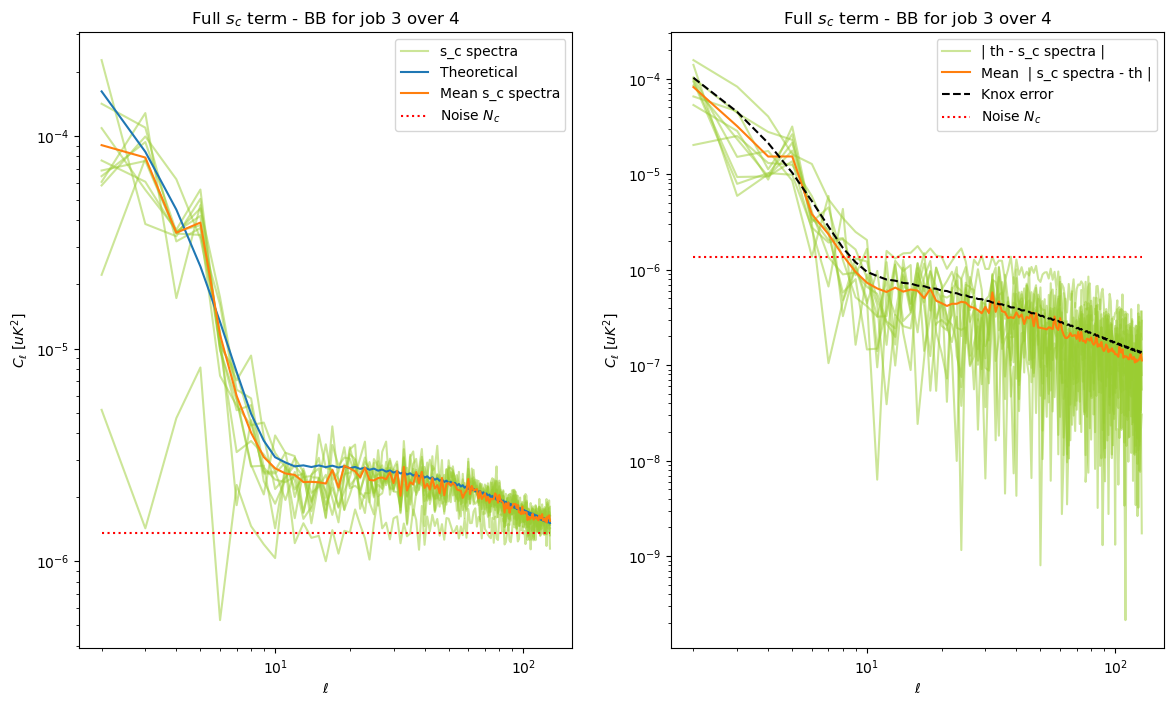

In [626]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

color_s_c_spectra = 'yellowgreen'

if MICMAC_sampler_obj.save_s_c_spectra:
    for job in range(num_jobs):
        plt.figure(figsize=(14,8))
        plt.subplot(121)
        
        number_s_c_samples = MICMAC_sampler_obj.number_iterations_sampling
        number_s_c_samples = all_s_c_spectra.shape[1]

        plt.plot(ell_arange, all_s_c_spectra[job, 1, 1, :], color_s_c_spectra, alpha=.5, label='s_c spectra')
        for iteration in range(2,number_s_c_samples,sub_step_sampling):
            plt.plot(ell_arange, all_s_c_spectra[job, iteration, 1, :], color_s_c_spectra, alpha=.5)
        
        plt.plot(ell_arange, MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor[:,1,1] + theoretical_red_cov_r0_total[:,1,1], color='tab:blue', label='Theoretical')
        plt.plot(ell_arange, all_s_c_spectra[job, :, 1, :].mean(axis=0), 'tab:orange', label='Mean s_c spectra')
        mixing_matrix_sampled = MICMAC_sampler_obj.get_B_from_params(init_params, jax_use=True)
        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
        
        plt.plot(ell_arange, _cl_noise_harm, 'r:', label='Noise $N_c$')

        plt.title(f"Full $s_c$ term - {list_correl[1]} for job {job} over {num_jobs}")
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.loglog()
        # plt.yscale('log')
        plt.legend()

        plt.subplot(122)

        theoretical_spectrum = MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor[:,1,1] + theoretical_red_cov_r0_total[:,1,1]

        

        plt.plot(ell_arange, np.abs(all_s_c_spectra[job, 1, 1, :]-theoretical_spectrum), color_s_c_spectra, alpha=.5, label='| th - s_c spectra |')
        for iteration in range(2,number_s_c_samples,sub_step_sampling):
            plt.plot(ell_arange, np.abs(all_s_c_spectra[job, iteration, 1, :]-theoretical_spectrum), color_s_c_spectra, alpha=.5)

        plt.plot(ell_arange, np.abs(all_s_c_spectra[job, :, 1, :]-theoretical_spectrum).mean(axis=0), 'tab:orange', label='Mean  | s_c spectra - th |')

        plt.plot(ell_arange, theoretical_spectrum*np.sqrt(2/((2*ell_arange+1))), 'black', label='Knox error', linestyle='--')
        mixing_matrix_sampled = MICMAC_sampler_obj.get_B_from_params(init_params, jax_use=True)
        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
        
        plt.plot(ell_arange, _cl_noise_harm, 'r:', label='Noise $N_c$')

        plt.title(f"Full $s_c$ term - {list_correl[1]} for job {job} over {num_jobs}")
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.loglog()
        # plt.yscale('log')
        plt.legend()



    plt.show()

In [627]:
# mask = hp.read_map("/Users/mag/Documents/PHD1Y/Masks/Planck_mask_fsky_60.fits")

# hp.mollview(mask)

In [628]:
# test_ = MICMAC_sampler_obj.get_band_limited_maps(right_member_0 + right_member_1)

# hp.mollview(test_[0,...] - 2*right_member_1[0])
# hp.mollview(test_[1,...] - 2*right_member_1[1])
# plt.show()

# Plot $C$

In [629]:
if MICMAC_sampler_obj.sample_C_inv_Wishart and not(np.isnan(all_cell_samples).any()):
    job_index = 0
    nstokes_select = 1
    ell_select = 0
    burnin = 0
    selection = all_cell_samples[job_index,burnin:,nstokes_select,ell_select]

    n_sigma = 3
    transformed_samples = np.abs(selection - selection.mean())/(selection.std()) #< n_sigma
    cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    mean_r = np.round(selection[cond].mean(), decimals=5)
    std_r = np.round(selection[cond].std(), decimals=5)

    # hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins='rice')
    hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins=1000)
    plt.plot([c_ell_true_CMB[nstokes_select,ell_select],c_ell_true_CMB[nstokes_select,ell_select]], [0,hist_nb.max()], 'r--', label='True CMB')
    plt.plot([selection.mean(),selection.mean()], [0,hist_nb.max()], '--', color='darkseagreen', label='Mean sample')
    plt.xscale('log')
    # (all_cell_samples
    plt.legend()
    plt.show()

In [630]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    any_nan = np.argwhere(np.isnan(all_cell_samples[job_index]))

    print("First nan appear :", any_nan[:MICMAC_sampler_obj.nstokes+1])

In [631]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    ell_to_probe = 10 #0
    correl = 1

    plt.figure(figsize=(14,5))
    true_CMB_ell = c_ell_true_CMB[correl,ell_to_probe]#*(2*(ell_to_probe+MICMAC_sampler_obj.lmin)+1)#**2

    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1)+1, all_cell_samples[job_index,:,correl,ell_to_probe])
    plt.plot([-1,MICMAC_sampler_obj.number_iterations_sampling+1], [true_CMB_ell,true_CMB_ell], label='True CMB')

    plt.xlabel("Iteration")
    plt.ylabel(r"$C_\ell$ [$uK^2$]")
    plt.loglog()
    # plt.ylim(ymin=0.00015, ymax=0.00017)
    plt.legend()
    plt.show()


In [632]:
input_cmb_maps.shape

(4, 1, 2, 49152)

In [633]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    plt.plot(ell_arange, all_cell_samples[job_index,721].T)
    plt.loglog()
    plt.show()

In [634]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    plt.plot(ell_arange[75:85], all_cell_samples[job_index,722,:,75:85].T)

    # plt.loglog()
    plt.yscale('log')
    plt.show()

In [635]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    for job in range(num_jobs):
        input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[job,0,0]),input_cmb_maps[job,0]])
        cmb_anafast = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

        dict_color = {'fill': 'moccasin', 'border': 'orange'}
        dict_color_theoretical = {'fill': 'lightcoral', 'border': 'tab:red'}
        # curve_theoretical = cmb_anafast
        # std_theoretical = cmb_anafast*np.sqrt(2/(2*ell_arange+1))# Knox cosmic covariance
        c_ell_mean = np.mean(all_cell_samples[job], axis=0)
        # c_ell_mean = np.mean(all_cell_samples[500:], axis=0)
        # c_ell_mean = np.mean(all_cell_samples[-2:], axis=0)

        list_correl = ['EE', 'BB', 'EB']

        ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
        factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
        factor[0] = 1
        # factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2))
        # factor = ell_arange*(ell_arange+1)/(2*np.pi)
        plt.figure(figsize=(15,10))
        for j in range(n_correl_to_plot):
            plt.subplot(311+j)
            plt.title(list_correl[j])
            if j > MICMAC_sampler_obj.nstokes-1:
                plt.title(list_correl[j] + ' with incorrect ell=2 !')

            curve_theoretical = cmb_anafast[j]
            std_theoretical = cmb_anafast[j]*np.sqrt(2/(2*ell_arange+1))
            plt.plot(ell_arange, curve_theoretical, color=dict_color_theoretical['border'], label='Anafast CMB $\pm$ Knox')
            plt.fill_between(ell_arange, curve_theoretical-std_theoretical, curve_theoretical+std_theoretical, color=dict_color_theoretical['fill'], alpha=0.2)
            plt.plot(ell_arange, curve_theoretical-std_theoretical, color=dict_color_theoretical['border'], alpha=0.6)
            plt.plot(ell_arange, curve_theoretical+std_theoretical, color=dict_color_theoretical['border'], alpha=0.6)

            plt.plot(ell_arange, c_ell_mean[j]/factor, '--', color=dict_color['border'], label='Mean value samples C')
            
            curve = c_ell_mean[j]
            std_curve = np.std(all_cell_samples[job,:,j,...], axis=0)

            plt.fill_between(ell_arange, (curve-std_curve)/factor, (curve+std_curve)/factor, color=dict_color['fill'], alpha=0.2)
            plt.plot(ell_arange, (curve-std_curve)/factor, color=dict_color['border'], alpha=0.6)
            plt.plot(ell_arange, (curve+std_curve)/factor, color=dict_color['border'], alpha=0.6)
            plt.plot(ell_arange, c_ell_true_CMB[j], color='tab:blue', label='True CMB')

            if j < MICMAC_sampler_obj.nstokes:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.loglog()
            plt.legend()
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
    plt.show()

In [636]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    for job in range(num_jobs):
        dict_color = {'fill': 'moccasin', 'border': 'orange'}

        list_correl = ['EE', 'BB', 'EB']

        ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
        # factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
        plt.figure(figsize=(15,10))
        for j in range(n_correl_to_plot):
            plt.subplot(311+j)
            plt.title(list_correl[j])

            plt.plot(ell_arange, c_ell_true_CMB[j], label='True CMB')
            for ell in range(c_ell_mean.shape[1]):
                plt.plot(ell_arange[ell]*np.ones(MICMAC_sampler_obj.number_iterations_sampling+1), all_cell_samples[job,:,j,ell], '.', color=dict_color['border'], alpha=0.1)
            # plt.plot(ell_arange, all_cell_samples[:,j,:].T, '.', color=dict_color['border'], label='Mean value samples C')

            if j < MICMAC_sampler_obj.nstokes:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.loglog()
            plt.legend()
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
    plt.show()

# Getting r from anafast

In [637]:
def get_r_estimate_B(input_cmb_map, mask_=np.ones(MICMAC_sampler_obj.n_pix)):
    indices_polar = np.array([1,2])

    input_cmb_maps_ = np.copy(input_cmb_map[0,0])

    f_sky = mask_.sum()/mask_.size

    map_CMB_extended = np.vstack([np.zeros_like(input_cmb_maps_[0]), input_cmb_maps_])
    c_ell_CMB_map_0 = hp.anafast(map_CMB_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]#*(2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) 

    select_B_modes = np.eye(MICMAC_sampler_obj.nstokes)
    select_B_modes[0,0] = 0
    red_select_B_modes = np.einsum('l,ij->lij', np.ones(MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin), select_B_modes)

    input_CMB_map_without_E_modes = micmac.maps_x_red_covariance_cell_JAX(input_cmb_maps_, 
                                                                        red_select_B_modes, 
                                                                        nside=MICMAC_sampler_obj.nside, 
                                                                        lmin=MICMAC_sampler_obj.lmin, 
                                                                        n_iter=MICMAC_sampler_obj.n_iter)

    map_CMB_without_E_modes_extended = np.vstack([np.zeros_like(input_CMB_map_without_E_modes[0]), input_CMB_map_without_E_modes])*mask_
    c_ell_CMB_map_without_E_modes_0 = hp.anafast(map_CMB_without_E_modes_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]#*(2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) 

    c_ell_BB_CMB_map = c_ell_CMB_map_without_E_modes_0[1]*(2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1)/f_sky


    theoretical_func_r = lambda r: r*theoretical_red_cov_r1_tensor[:,1,1] + theoretical_red_cov_r0_total[:,1,1]

    sum_dets = lambda r: ( (2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) * jnp.log(theoretical_func_r(r))).sum()

    likelihood_func = lambda r: ((c_ell_BB_CMB_map/theoretical_func_r(r)).sum() + sum_dets(r))/2

    r_estimate = scipy.optimize.minimize_scalar(likelihood_func, bounds=(0, 1), method='bounded').x
    return r_estimate, c_ell_CMB_map_without_E_modes_0[1]

r_anafast, pure_B_spectra = get_r_estimate_B(input_cmb_maps, mask)
r_anafast

Array(0.00945596, dtype=float64)

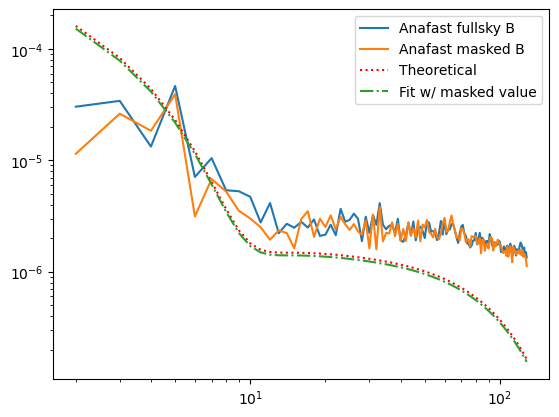

In [638]:
f_sky = mask.sum()/mask.size

input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,0,...]), input_cmb_maps[0,0]])
fullsky_anafast_BB = hp.anafast(input_cmb_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[2,MICMAC_sampler_obj.lmin:]#*(2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) 


plt.plot(ell_arange, fullsky_anafast_BB, label='Anafast fullsky B')
plt.plot(ell_arange, pure_B_spectra/f_sky, label='Anafast masked B')
plt.plot(ell_arange, MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor[:,1,1], 'r:', label='Theoretical')
plt.plot(ell_arange, r_anafast*theoretical_red_cov_r1_tensor[:,1,1], '-.', label='Fit w/ masked value')
plt.legend()
plt.loglog()
plt.show()

# Studying $r$

In [639]:
burn_in = int(.9*MICMAC_sampler_obj.number_iterations_sampling)
burn_in = 1500
burn_in = 400

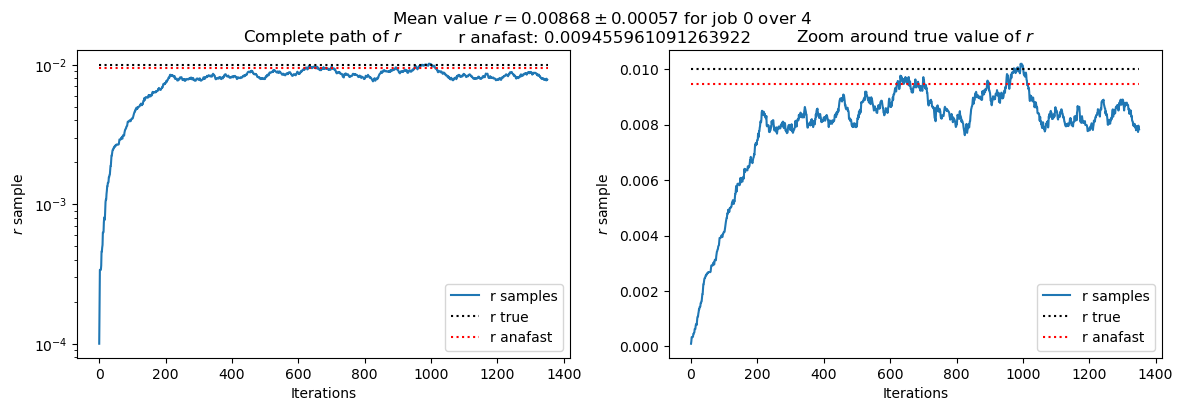

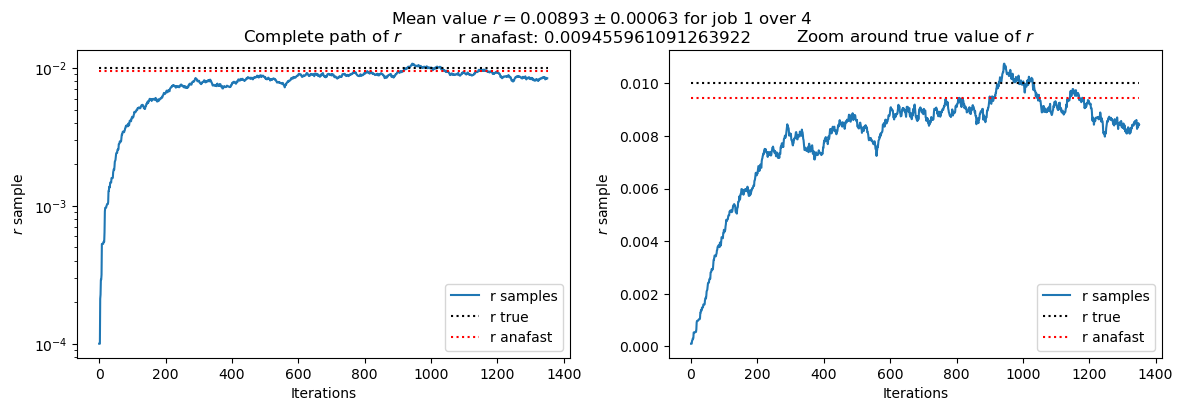

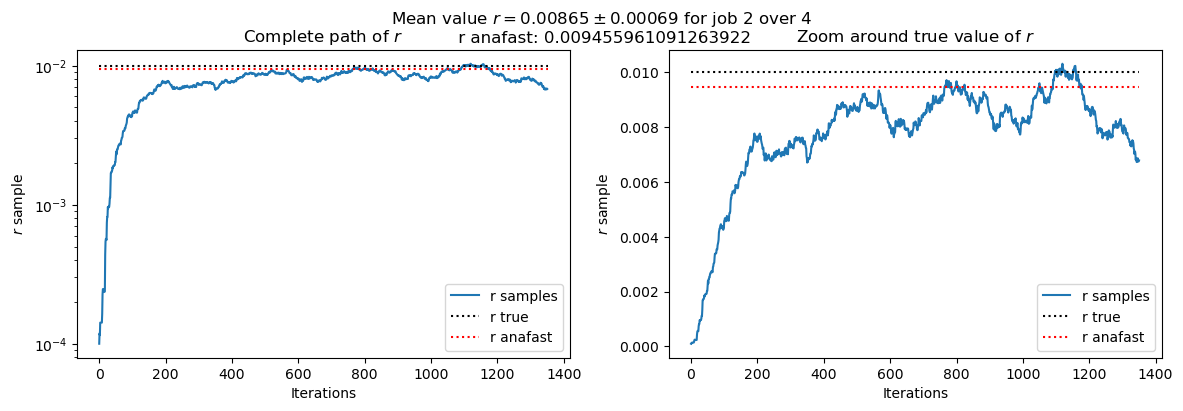

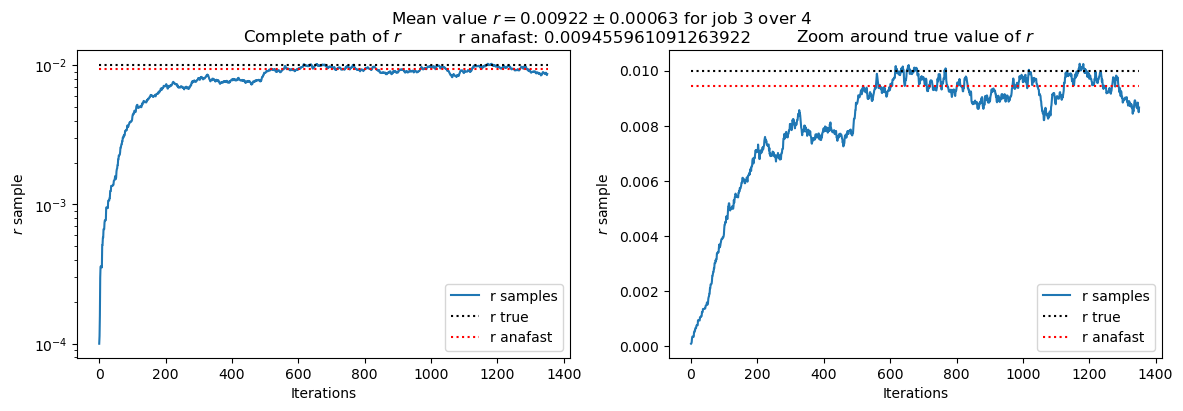

In [640]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        plt.figure(figsize=(14,4))
        
        max_number_iterations_r = MICMAC_sampler_obj.number_iterations_sampling+1
        if len(all_r_samples.shape) == 4:
            max_number_iterations_r = all_r_samples.shape[1]*all_r_samples.shape[2]
        else:
            max_number_iterations_r = all_r_samples.shape[1]
        # n_sigma = 3
        
        # cond = np.abs((all_r_samples[job] - all_r_samples[job].mean())/(all_r_samples[job].std())) < n_sigma
        cond = np.arange(max_number_iterations_r) > burn_in
        # print(all_r_samples[job,cond].shape, MICMAC_sampler_obj.number_iterations_sampling)

        

        all_r_samples_job = all_r_samples[job].squeeze().reshape(max_number_iterations_r,1)

        if MICMAC_sampler_obj.non_centered_moves:
            full_cond = np.logical_and(cond, np.arange(max_number_iterations_r)%2 == 1)
            mean_r = np.round(all_r_samples_job[full_cond].mean(), decimals=5)
            std_r = np.round(all_r_samples_job[full_cond].std(), decimals=5)
        else:
            mean_r = np.round(all_r_samples[job,cond].mean(), decimals=5)
            std_r = np.round(all_r_samples[job,cond].std(), decimals=5)

        plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ for job {job} over {num_jobs}\n r anafast: {r_anafast}")
        plt.subplot(121)
        # plt.plot(np.arange(max_number_iterations_r), all_r_samples[job], label='r samples')
        plt.plot(np.arange(max_number_iterations_r), all_r_samples_job, label='r samples')
        plt.plot([0,max_number_iterations_r], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
        plt.plot([0, max_number_iterations_r], [r_anafast,r_anafast], 'r:', label='r anafast')

        plt.yscale('log')
        plt.xlabel("Iterations")
        plt.ylabel('$r$ sample')
        plt.title('Complete path of $r$')
        plt.legend()

        plt.subplot(122)
        # plt.plot(np.arange(max_number_iterations_r), all_r_samples[job], label='r samples')
        plt.plot(np.arange(max_number_iterations_r), all_r_samples_job, label='r samples')
        plt.plot([0, max_number_iterations_r], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
        plt.plot([0, max_number_iterations_r], [r_anafast,r_anafast], 'r:', label='r anafast')
        plt.xlabel("Iterations")
        plt.ylabel('$r$ sample')
        plt.title('Zoom around true value of $r$')
        plt.legend()
        # plt.ylim(ymin=MICMAC_sampler_obj.r_true*.7, ymax=MICMAC_sampler_obj.r_true*1.3)
    plt.show()

In [641]:
if MICMAC_sampler_obj.non_centered_moves:
    all_r_samples_test = all_r_samples.squeeze()

    print(all_r_samples_test[:,0] - all_r_samples_test[:,1])

In [642]:
all_r_samples[0,:].mean(), all_r_samples[0,-1000:].mean(), all_r_samples[0,-500:].mean(), all_r_samples[0,-100:].mean()

(0.007909507941769464,
 0.008651678451258625,
 0.008676601081722217,
 0.00839161060604402)

In [643]:
# all_r_samples[2000:].mean(), all_r_samples[2000:].std()

0.007909507941769464 0.0018459229382274758
0.007982218970420509 0.0019964594215211543
0.007780681663905969 0.0019145438441114423
0.008170531252406098 0.0021387299110691748


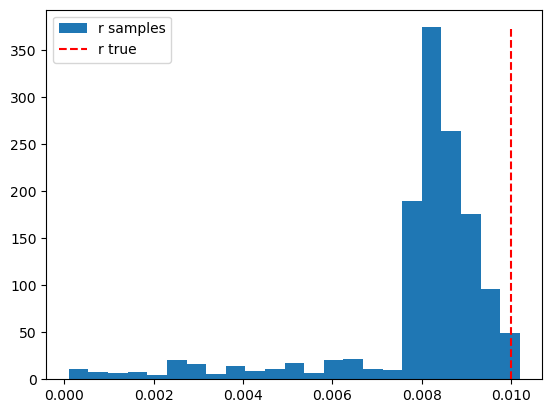

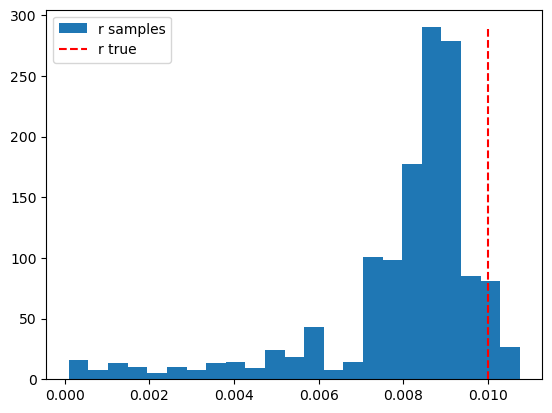

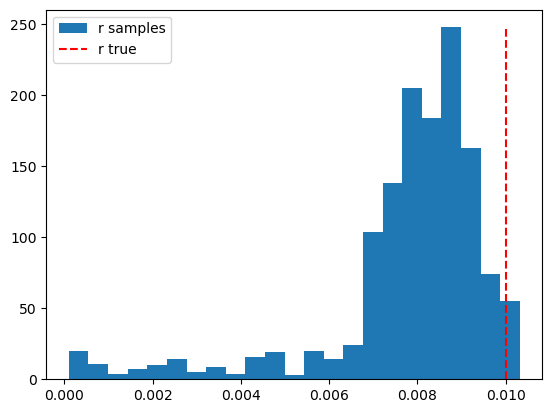

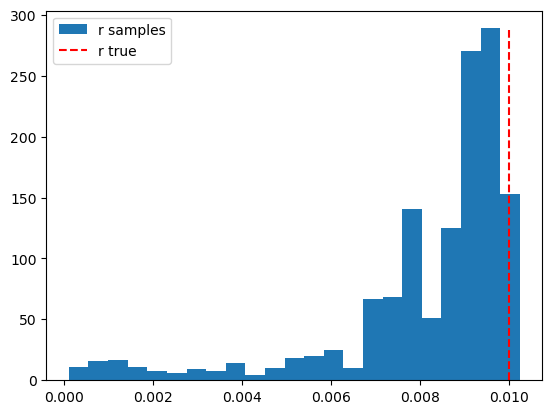

In [644]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        plt.figure()
        hist_values, bins_value, _ = plt.hist(all_r_samples[job], bins='rice', label='r samples')
        plt.plot([MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
        plt.legend()
        print(np.mean(all_r_samples[job]), np.std(all_r_samples[job]))
    plt.show()

In [645]:
number_parameters_B_f_samples = all_params_mixing_matrix_samples.shape[-1]
number_params_B_f_nside0 = (MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs))*(MICMAC_sampler_obj.n_components-1)

In [646]:
MICMAC_sampler_obj.update_params(init_params)
mixing_matrix_sampled = MICMAC_sampler_obj.get_B()
BtinvNB_true = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)

# if number_parameters_B_f_samples == number_params_B_f_nside0:
if MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        all_mixing_matrix = np.zeros((MICMAC_sampler_obj.number_iterations_sampling+1,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_components))

        all_mixing_matrix[:,:,0] = mixing_matrix_sampled[:,0,0]
        all_mixing_matrix[:,0,:] = mixing_matrix_sampled[0,:,0]
        all_mixing_matrix[:,-1,:] = mixing_matrix_sampled[-1,:,0]
        
        cumsum_size_patches = np.zeros(MICMAC_sampler_obj.size_patches.shape[0]+1, dtype=int)
        cumsum_size_patches[1:] = MICMAC_sampler_obj.size_patches.cumsum()
        for i in range((MICMAC_sampler_obj.size_patches.shape[0])):
            all_mixing_matrix[:,i%(MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs))+1, i//(MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs))+1] = all_params_mixing_matrix_samples[job,:,cumsum_size_patches[i]:cumsum_size_patches[i+1]].mean(axis=1)
        # all_mixing_matrix[:,1:-1,1] = all_params_mixing_matrix_samples[job,:,:MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs)]
        # all_mixing_matrix[:,1:-1,2] = all_params_mixing_matrix_samples[job,:,MICMAC_sampler_obj.n_frequencies-len(MICMAC_sampler_obj.pos_special_freqs):]



        true_N_c = BtinvNB_true[0,0]
        cl_noise_harm_0 = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin]
        all_inv_N_c = jnp.linalg.pinv(jnp.einsum("ifc,fh,ihd->icd", all_mixing_matrix, MICMAC_sampler_obj.freq_inverse_noise.mean(axis=2), all_mixing_matrix))[:,0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
        # all_inv_N_c = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, iteration_mixing_matrix.mean(axis=2))[0,0]
        plt.figure()
        plt.title('Effective CMB Noise vs iterations')
        # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [true_N_c,true_N_c], label='true N_c')
        plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [cl_noise_harm_0,cl_noise_harm_0], label='true N_c')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_inv_N_c, '-.', label='sample N_c')

        plt.xlabel('Iterations')
        plt.ylabel('$N_c^{-1}$ [uK$^-2$]')
        # plt.loglog()
        # plt.xscale('log')
        # plt.yscale('log')
        plt.legend()
    plt.show()

## Plots without spatial variability

In [647]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = frequency_Bf.shape[0]
if number_parameters_B_f_samples == number_params_B_f_nside0 and MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:dim_Bf]
        all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,dim_Bf:]

        frequency_array = np.array(instrument['frequency'])


        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            plt.figure(figsize=(20,8))
            plt.suptitle('Mixing matrix parameters sampled vs iterations for job {} over {}'.format(job,num_jobs), fontsize=14)
            # plt.subplot(121)

            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i],init_params[i]], label='Exact value')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
                
                n_sigma = 3
                transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
                cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
                std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

                mean_value = all_B_f_sample_synch[:,i].mean()
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

                # plt.yscale('log')
                # plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

            # plt.figure(figsize=(20,8))
            # plt.subplot(122)
            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                # plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i+dim_Bf],init_params[i+dim_Bf]], label='Exact value')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

                n_sigma = 3
                transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
                cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
                std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

                mean_value = all_B_f_sample_dust[:,i].mean()
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
                # plt.yscale('log')
                plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()
            

        plt.show()

In [648]:
all_params_mixing_matrix_samples.shape

(4, 1351, 1)

In [649]:
all_params_mixing_matrix_samples

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [650]:
MICMAC_sampler_obj.get_B(jax_use=True)

Array([[[1., 1., 1., ..., 1., 1., 1.]]], dtype=float64)

In [651]:
if MICMAC_sampler_obj.n_components != 1:
    MICMAC_sampler_obj.update_params(all_params_mixing_matrix_samples[0,-1], jax_use=True)
    test_mixing_matrix = MICMAC_sampler_obj.get_B(jax_use=True)
    hp.mollview(test_mixing_matrix[4,2], title="Mixing matrix main dust element for last iteration")

In [652]:
# all_params_mixing_matrix_samples[0,:,12:24].std(axis=0)
for i in range(8):
    print(all_params_mixing_matrix_samples[0,:,12*i:(i+1)*12].std(axis=0))

[0.]
[]
[]
[]
[]
[]
[]
[]


In [653]:
all_params_mixing_matrix_samples[0,-1]

array([0.])

In [654]:
MICMAC_sampler_obj.update_params(init_params)
MICMAC_sampler_obj.params

Array([], dtype=float64)

In [655]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = frequency_Bf.shape[0]
if MICMAC_sampler_obj.len_params == (MICMAC_sampler_obj.n_components - 1)*len(frequency_Bf) and MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:dim_Bf]
        all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,dim_Bf:]

        frequency_array = np.array(instrument['frequency'])


        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
            n_columns = 4
            number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

            # plt.figure(figsize=(20,8))
            fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
            useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
            for idx_useless in range(0,useless_plots):
                num_row = (number_rows*n_columns)//n_columns
                num_col = (number_rows*n_columns)%n_columns
                fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

            fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
            # plt.subplot(121)

            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                # plt.subplot(201+len(frequency_Bf)*10+i)
                num_row = i//n_columns
                num_col = i%n_columns
                ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
                # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
                
                ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i],init_params[i]], label='Exact value')
                ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
                
                mean_value = all_B_f_sample_synch[:,i].mean()
                ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_value,mean_value], ':', label='Samples mean')

                # plt.yscale('log')
                # plt.xlabel('Iterations')
                ax[num_row, num_col].set_xlabel('Iterations')
                if i == 0:
                    # plt.ylabel('Amplitude')
                    ax[num_row, num_col].set_ylabel('Amplitude')
                if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                    ax[num_row, num_col].set_xlabel('Iterations')
                else:
                    ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
            ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

            # plt.figure(figsize=(20,8))
            # plt.subplot(122)
            fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
            useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
            for idx_useless in range(0,useless_plots):
                num_row = (number_rows*n_columns)//n_columns
                num_col = (number_rows*n_columns)%n_columns
                fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


            fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
            
            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                # plt.subplot(201+len(frequency_Bf)*10+i)
                num_row = i//n_columns
                num_col = i%n_columns
                ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
                ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i+dim_Bf],init_params[i+dim_Bf]], label='Exact value')
                ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

                mean_value = all_B_f_sample_dust[:,i].mean()
                ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_value,mean_value], ':', label='Samples mean')
                # plt.yscale('log')
                
                if i == 0:
                    ax[num_row, num_col].set_ylabel('Amplitude')
                if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                    ax[num_row, num_col].set_xlabel('Iterations')
                else:
                    ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
            ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

        plt.show()

In [656]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']
if MICMAC_sampler_obj.len_params == (MICMAC_sampler_obj.n_components - 1)*len(frequency_Bf) and MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job]
            plt.figure(figsize=(18,8))
            plt.suptitle(f"Mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)

            for i in range(len(frequency_Bf)):
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch {frequency_Bf[i]} GHz'))
                if all_params_mixing_matrix_samples_job[:,i].min() == all_params_mixing_matrix_samples_job[:,i].max():
                    min_value = all_params_mixing_matrix_samples_job[:,i].min()*.9
                    max_value = all_params_mixing_matrix_samples_job[:,i].max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job[:,i].min()
                    max_value = all_params_mixing_matrix_samples_job[:,i].max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())
                # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
                plt.plot([init_params[i],init_params[i]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


            for i in range(len(frequency_Bf)):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                plt.title((f'Dust {frequency_Bf[i]} GHz'))
                if all_params_mixing_matrix_samples_job[:,i+dim_Bf].min() == all_params_mixing_matrix_samples_job[:,i+dim_Bf].max():
                    min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()*.9
                    max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()
                    max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i+dim_Bf], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())

                # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
                plt.plot([init_params[i+dim_Bf],init_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
            # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

        plt.show()


## Selecting $B_f$ in the observed region in case of spatial variability

In [657]:
if MICMAC_sampler_obj.n_components != 1:
    condition_unobserved_patches = MICMAC_sampler_obj.get_cond_unobserved_patches() ## Get boolean array to identify which free indexes are not relevant
    print("Previous free indexes for B_f", MICMAC_sampler_obj.indexes_free_Bf, MICMAC_sampler_obj.indexes_free_Bf.size, flush=True)
    MICMAC_sampler_obj.indexes_free_Bf = jnp.array(MICMAC_sampler_obj.indexes_free_Bf).at[condition_unobserved_patches].get()
    print("New free indexes for B_f", MICMAC_sampler_obj.indexes_free_Bf, MICMAC_sampler_obj.indexes_free_Bf.size, flush=True)

    indexes_free_Bf = MICMAC_sampler_obj.indexes_free_Bf


## Plotting chains of $B_f$

In [658]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = frequency_Bf.shape[0]

alpha_value = .4
number_params_synch = MICMAC_sampler_obj.indexes_b[0,1]

if number_parameters_B_f_samples != number_params_B_f_nside0 and MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        
        all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:number_params_synch]
        all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,number_params_synch:]

        frequency_array = np.array(instrument['frequency'])


        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            plt.figure(figsize=(20,8))
            plt.suptitle('Mixing matrix parameters sampled vs iterations for job {} over {}'.format(job,num_jobs), fontsize=14)
            # plt.subplot(121)

            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
                
                indices_to_plot = MICMAC_sampler_obj.indexes_b[i,0] + np.arange(MICMAC_sampler_obj.size_patches[i])
                indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_sampler_obj.indexes_free_Bf)]
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[indices_to_plot[0]],init_params[indices_to_plot[0]]], label='Exact value', color='tab:blue')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,MICMAC_sampler_obj.indexes_b[i,0]], '-.', color='tab:orange', label='Sample', alpha=alpha_value)
                
                for j in indices_to_plot[1:]:
                    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[j],init_params[j]], color='tab:blue')
                    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,j], '-.', color='tab:orange', alpha=alpha_value)
                
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

            # plt.figure(figsize=(20,8))
            # plt.subplot(122)
            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                # plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i+dim_Bf],init_params[i+dim_Bf]], label='Exact value')
                # plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

                indices_to_plot = MICMAC_sampler_obj.indexes_b[i,1] + np.arange(MICMAC_sampler_obj.size_patches[i+number_params_synch])
                indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_sampler_obj.indexes_free_Bf)]
                plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[indices_to_plot[0]],init_params[indices_to_plot[0]]], label='Exact value', color='tab:blue')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,indices_to_plot[0]], '-.', color='tab:orange', label='Sample', alpha=alpha_value)
                
                for j in indices_to_plot[1:]:
                    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[j],init_params[j]], color='tab:blue')
                    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,j], '-.', color='tab:orange', alpha=alpha_value)

                plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()
            

        plt.show()

In [659]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = frequency_Bf.shape[0]
number_params_synch = MICMAC_sampler_obj.indexes_b[0,1]

if MICMAC_sampler_obj.n_components != 1:
    if MICMAC_sampler_obj.max_len_patches_Bf < 1000:
        for job in range(num_jobs):
            # all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:dim_Bf]
            # all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,dim_Bf:]

            frequency_array = np.array(instrument['frequency'])


            if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
                n_columns = 4
                number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

                # plt.figure(figsize=(20,8))
                fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
                useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
                for idx_useless in range(0,useless_plots):
                    num_row = (number_rows*n_columns)//n_columns
                    num_col = (number_rows*n_columns)%n_columns
                    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

                fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
                # plt.subplot(121)

                for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                    # plt.subplot(201+len(frequency_Bf)*10+i)


                    num_row = i//n_columns
                    num_col = i%n_columns
                    ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
                    # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
                    
                    # ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i],init_params[i]], label='Exact value')
                    # ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
                    
                    indices_to_plot = MICMAC_sampler_obj.indexes_b[i,0] + np.arange(MICMAC_sampler_obj.size_patches[i])
                    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_sampler_obj.indexes_free_Bf)]
                    ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[indices_to_plot[0]],init_params[indices_to_plot[0]]], label='Exact value', color='tab:blue')
                    ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,indices_to_plot[0]], '-.', color='tab:orange', label='Sample', alpha=alpha_value)
                    
                    for idx_plot in indices_to_plot[1:]:
                        ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[idx_plot],init_params[idx_plot]], color='tab:blue')
                        ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,idx_plot], '-.', color='tab:orange', alpha=alpha_value)
                    
                    # plt.yscale('log')
                    # plt.xlabel('Iterations')
                    # ax[num_row, num_col].set_xlabel('Iterations')
                    if i == 0:
                        # plt.ylabel('Amplitude')
                        ax[num_row, num_col].set_ylabel('Amplitude')
                    if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                        ax[num_row, num_col].set_xlabel('Iterations')
                    else:
                        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
                ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
                # plt.loglog()

                # plt.figure(figsize=(20,8))
                # plt.subplot(122)
                fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
                useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
                for idx_useless in range(0,useless_plots):
                    num_row = (number_rows*n_columns)//n_columns
                    num_col = (number_rows*n_columns)%n_columns
                    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


                fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
                
                for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                    num_row = i//n_columns
                    num_col = i%n_columns
                    ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
                    
                    indices_to_plot = MICMAC_sampler_obj.indexes_b[i,1] + np.arange(MICMAC_sampler_obj.size_patches[i+number_params_synch])
                    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_sampler_obj.indexes_free_Bf)]
                    ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[indices_to_plot[0]],init_params[indices_to_plot[0]]], label='Exact value', color='tab:blue')
                    ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,indices_to_plot[0]], '-.', color='tab:orange', label='Sample', alpha=alpha_value)
                    
                    for idx_mixing in indices_to_plot[1:]:
                        ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[idx_mixing],init_params[idx_mixing]], color='tab:blue')
                        ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_params_mixing_matrix_samples[job,:,idx_mixing], '-.', color='tab:orange', alpha=alpha_value)

                    if i == 0:
                        ax[num_row, num_col].set_ylabel('Amplitude')
                    if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                        ax[num_row, num_col].set_xlabel('Iterations')
                    else:
                        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
                ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
                # plt.loglog()

            plt.show()

In [660]:
if MICMAC_sampler_obj.n_components != 1:
    if MICMAC_sampler_obj.size_patches.max() > 1:
        frequency_Bf = np.array(instrument['frequency'][1:-1])
        number_free_Bf = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*(MICMAC_sampler_obj.n_components - 1)
        extended_array = np.zeros((number_free_Bf+1),dtype=np.int64)
        extended_array[:-1] = MICMAC_sampler_obj.indexes_b.ravel(order='F')
        extended_array[-1] = extended_array[:-1].max() + MICMAC_sampler_obj.size_patches[-1]

        for i in range(number_free_Bf):
            print("Var param", i, ":", all_params_mixing_matrix_samples[0,:,i].std())
            freq = i//(MICMAC_sampler_obj.n_components - 1)
            comp = i%(MICMAC_sampler_obj.n_components - 1)
            hp.mollview(all_params_mixing_matrix_samples[0,:,extended_array[i]:extended_array[i+1]].std(axis=0), title=f"Param freq {frequency_Bf[freq]} GHz, comp {comp}")

In [661]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']
if MICMAC_sampler_obj.len_params == (MICMAC_sampler_obj.n_components - 1)*len(frequency_Bf) and MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
            all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job]
            # plt.figure(figsize=(18,8))
            fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
            fig.suptitle(f"Synch mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
            useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
            for idx_useless in range(0,useless_plots):
                num_row = (number_rows*n_columns)//n_columns
                num_col = (number_rows*n_columns)%n_columns
                fig.delaxes(ax[num_row-1, num_col-idx_useless-1])
                

            for i in range(len(frequency_Bf)):
                num_row = i//n_columns
                num_col = i%n_columns
            
                # plt.subplot(201+len(frequency_Bf)*10+i)
                ax[num_row, num_col].set_title((f'Synch {frequency_Bf[i]} GHz'))
                # plt.title((f'Synch {frequency_Bf[i]} GHz'))
                if all_params_mixing_matrix_samples_job[:,i].min() == all_params_mixing_matrix_samples_job[:,i].max():
                    min_value = all_params_mixing_matrix_samples_job[:,i].min()*.9
                    max_value = all_params_mixing_matrix_samples_job[:,i].max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job[:,i].min()
                    max_value = all_params_mixing_matrix_samples_job[:,i].max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())
                # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
                ax[num_row, num_col].plot([init_params[i],init_params[i]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
            ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


            fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
            fig.suptitle(f"Dust mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
            useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
            for idx_useless in range(0,useless_plots):
                num_row = (number_rows*n_columns)//n_columns
                num_col = (number_rows*n_columns)%n_columns
                fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

            for i in range(len(frequency_Bf)):
                num_row = i//n_columns
                num_col = i%n_columns
                # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                ax[num_row, num_col].set_title((f'Dust {frequency_Bf[i]} GHz'))
                if all_params_mixing_matrix_samples_job[:,i+dim_Bf].min() == all_params_mixing_matrix_samples_job[:,i+dim_Bf].max():
                    min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()*.9
                    max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()*1.1
                else:
                    min_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].min()
                    max_value = all_params_mixing_matrix_samples_job[:,i+dim_Bf].max()
                bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                max_height = 0
                for j in range(num_iter_1000):
                    heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i+dim_Bf], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                    max_height = max(max_height, heights.max())

                # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
                ax[num_row, num_col].plot([init_params[i+dim_Bf],init_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
            ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

        plt.show()


In [662]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

alpha_value = .4

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']
if MICMAC_sampler_obj.n_components != 1:

    idx_patches = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*(MICMAC_sampler_obj.n_components - 1)+1)
    idx_patches[:-1] = MICMAC_sampler_obj.indexes_b.ravel(order='F')
    idx_patches[-1] = idx_patches[:-1].max() + MICMAC_sampler_obj.size_patches[-1]

    if MICMAC_sampler_obj.len_params != (MICMAC_sampler_obj.n_components - 1)*len(frequency_Bf) and MICMAC_sampler_obj.max_len_patches_Bf < 1000:
        for job in range(num_jobs):
            if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
                
                plt.figure(figsize=(18,8))
                plt.suptitle(f"Mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)

                for i in range(len(frequency_Bf)):
                    indices_to_plot = MICMAC_sampler_obj.indexes_b[i,1] + np.arange(MICMAC_sampler_obj.size_patches[i])
                    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_sampler_obj.indexes_free_Bf)]
                    
                    # idx_patch = np.arange(idx_patches[i],idx_patches[i+1], dtype=int)
                    all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job,:,indices_to_plot].T
                    plt.subplot(201+len(frequency_Bf)*10+i)
                    plt.title((f'Synch {frequency_Bf[i]} GHz'))
                    if all_params_mixing_matrix_samples_job.min() == all_params_mixing_matrix_samples_job.max():
                        min_value = all_params_mixing_matrix_samples_job.min()*.9
                        max_value = all_params_mixing_matrix_samples_job.max()*1.1
                    else:
                        min_value = all_params_mixing_matrix_samples_job.min()
                        max_value = all_params_mixing_matrix_samples_job.max()
                    bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                    max_height = 0
                    for j in range(num_iter_1000):
                        
                
                        heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,indices_to_plot[0]], bins=bins_array, color=color_list[j], alpha=alpha_value, label=f'#{j}e {1000}')
                        max_height = max(max_height, heights.max())
                        for k in indices_to_plot[1:]:
                            heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,k], bins=bins_array, color=color_list[j], alpha=alpha_value)
                            max_height = max(max_height, heights.max())
                        plt.plot([init_params[indices_to_plot[0]],init_params[indices_to_plot[0]]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
                        for k in indices_to_plot[1:]:
                            plt.plot([init_params[k],init_params[k]], [0,max_height], 'r:', linewidth=2.0)
                    # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
                    
                plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


                for i in range(len(frequency_Bf)):
                    plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                    plt.title((f'Dust {frequency_Bf[i]} GHz'))

                    # idx_patch = np.arange(idx_patches[i+dim_Bf],idx_patches[i+1+dim_Bf], dtype=int)
                    dim_dust = MICMAC_sampler_obj.indexes_b[0,1]
                    indices_to_plot = MICMAC_sampler_obj.indexes_b[i,1] + np.arange(MICMAC_sampler_obj.size_patches[i+dim_dust])
                    indices_to_plot = indices_to_plot[np.isin(indices_to_plot, MICMAC_sampler_obj.indexes_free_Bf)]
                    
                    all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job,:,indices_to_plot].T
                    if all_params_mixing_matrix_samples_job.min() == all_params_mixing_matrix_samples_job.max():
                        min_value = all_params_mixing_matrix_samples_job.min()*.9
                        max_value = all_params_mixing_matrix_samples_job.max()*1.1
                    else:
                        min_value = all_params_mixing_matrix_samples_job.min()
                        max_value = all_params_mixing_matrix_samples_job.max()
                    bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

                    # max_height = 0
                    # for j in range(num_iter_1000):
                    #     heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i+dim_Bf], bins=bins_array, color=color_list[j], alpha=.3, label=f'#{j}e {1000}')
                    #     max_height = max(max_height, heights.max())
                    max_height = 0
                    for j in range(num_iter_1000):
                        heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,indices_to_plot[0]], bins=bins_array, color=color_list[j], alpha=alpha_value, label=f'#{j}e {1000}')
                        max_height = max(max_height, heights.max())
                        for k in indices_to_plot[1:]:
                            heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,k], bins=bins_array, color=color_list[j], alpha=alpha_value)
                            max_height = max(max_height, heights.max())
                        # max_height = 1
                        plt.plot([init_params[indices_to_plot[0]],init_params[indices_to_plot[0]]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
                        for k in indices_to_plot[1:]:
                            plt.plot([init_params[k],init_params[k]], [0,max_height], 'r:', linewidth=2.0)

                    # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
                    # plt.plot([init_params[i+dim_Bf],init_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
                # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

            plt.show()


In [663]:
# list_correl = ['EE', 'BB', 'EB']

# ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

# frequency_Bf = np.array(instrument['frequency'][1:-1])
# frequency_array = np.array(instrument['frequency'])

# num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
# if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
#     num_iter_1000 += 1

# color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
#             'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
#             'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']
# if MICMAC_sampler_obj.max_len_patches_Bf < 1000 and (MICMAC_sampler_obj.len_params != (MICMAC_sampler_obj.n_components - 1)*len(frequency_Bf)):
#     for job in range(num_jobs):
#         if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
#             # all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job]
#             # plt.figure(figsize=(18,8))
#             fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
#             fig.suptitle(f"Synch mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
#             useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
#             for idx_useless in range(0,useless_plots):
#                 num_row = (number_rows*n_columns)//n_columns
#                 num_col = (number_rows*n_columns)%n_columns
#                 fig.delaxes(ax[num_row-1, num_col-idx_useless-1])
                

#             for i in range(len(frequency_Bf)):
#                 idx_patch = np.arange(idx_patches[i],idx_patches[i+1], dtype=int)
#                 all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job,:,idx_patch].T
#                 num_row = i//n_columns
#                 num_col = i%n_columns
            
#                 # plt.subplot(201+len(frequency_Bf)*10+i)
#                 ax[num_row, num_col].set_title((f'Synch {frequency_Bf[i]} GHz'))
#                 # plt.title((f'Synch {frequency_Bf[i]} GHz'))
#                 if all_params_mixing_matrix_samples_job.min() == all_params_mixing_matrix_samples_job.max():
#                     min_value = all_params_mixing_matrix_samples_job.min()*.9
#                     max_value = all_params_mixing_matrix_samples_job.max()*1.1
#                 else:
#                     min_value = all_params_mixing_matrix_samples_job.min()
#                     max_value = all_params_mixing_matrix_samples_job.max()
#                 bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

#                 max_height = 0
#                 for j in range(num_iter_1000):
#                     heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,0], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
#                     max_height = max(max_height, heights.max())
#                     for k in range(1,len(idx_patch)):
#                         heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,k], bins=bins_array, color=color_list[j], alpha=alpha_value)
#                         max_height = max(max_height, heights.max())
#                     ax[num_row, num_col].plot([init_params[idx_patch][0],init_params[idx_patch][0]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
#                     for k in range(1,len(idx_patch)):
#                         ax[num_row, num_col].plot([init_params[idx_patch][k],init_params[idx_patch][k]], [0,max_height], 'r:', linewidth=2.0)
#                 # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
#                 # ax[num_row, num_col].plot([init_params[i],init_params[i]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
#             ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


#             fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
#             fig.suptitle(f"Dust mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
#             useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
#             for idx_useless in range(0,useless_plots):
#                 num_row = (number_rows*n_columns)//n_columns
#                 num_col = (number_rows*n_columns)%n_columns
#                 fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

#             for i in range(len(frequency_Bf)):
#                 num_row = i//n_columns
#                 num_col = i%n_columns

#                 idx_patch = np.arange(idx_patches[i+dim_Bf],idx_patches[i+1+dim_Bf], dtype=int)
#                 dim_dust = MICMAC_sampler_obj.indexes_b[0,1]
#                 all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job,:,idx_patch].T
#                 # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
#                 ax[num_row, num_col].set_title((f'Dust {frequency_Bf[i]} GHz'))
#                 if all_params_mixing_matrix_samples_job.min() == all_params_mixing_matrix_samples_job.max():
#                     min_value = all_params_mixing_matrix_samples_job.min()*.9
#                     max_value = all_params_mixing_matrix_samples_job.max()*1.1
#                 else:
#                     min_value = all_params_mixing_matrix_samples_job.min()
#                     max_value = all_params_mixing_matrix_samples_job.max()
#                 bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

#                 max_height = 0
#                 for j in range(num_iter_1000):
#                     heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,0], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
#                     max_height = max(max_height, heights.max())
#                     for k in range(1,len(idx_patch)):
#                         heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,k], bins=bins_array, color=color_list[j], alpha=alpha_value)
#                         max_height = max(max_height, heights.max())
#                     # max_height = 1
#                     ax[num_row, num_col].plot([init_params[idx_patch][0],init_params[idx_patch][0]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
#                     for k in range(1,len(idx_patch)):
#                         ax[num_row, num_col].plot([init_params[idx_patch][k],init_params[idx_patch][k]], [0,max_height], 'r:', linewidth=2.0)

#                 # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
#                 # ax[num_row, num_col].plot([init_params[i+dim_Bf],init_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
#             ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
#             # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

#         plt.show()


In [664]:
cond = MICMAC_sampler_obj.number_iterations_sampling > 1500

In [665]:
# Residuals power spectrum
if MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        final_params = all_params_mixing_matrix_samples[job,-1]
        final_params = all_params_mixing_matrix_samples[job].mean(axis=0)
        # final_params = all_params_mixing_matrix_samples[job,1000:].mean(axis=0)
        final_params = all_params_mixing_matrix_samples[job,-1000:].mean(axis=0)
        # final_params = all_params_mixing_matrix_samples[job,cond].mean(axis=0)
        # final_params = all_params_mixing_matrix_samples[job,0]
        # final_params = all_params_mixing_matrix_samples[job,:1000].mean(axis=0)
        # final_params = all_params_mixing_matrix_samples[job,1000]
        # final_params = all_params_mixing_matrix_samples[job,:num_sample_AM].mean(axis=0)
        # final_params = all_params_mixing_matrix_samples[job,num_sample_AM:].mean(axis=0)
        # final_params = all_params_mixing_matrix_samples[job,2000:].mean(axis=0)

        MICMAC_sampler_obj.update_params(final_params)
        final_mixing_matrix = MICMAC_sampler_obj.get_B()

        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), final_mixing_matrix.mean(axis=2), lmax)[0,0,lmin:]
        red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
        cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

        recovered_CMB_Wd = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, final_mixing_matrix, initial_freq_maps[job], jax_use=False)[0, :, :]

        MICMAC_sampler_obj.update_params(init_params)
        init_mixing_matrix_obj = MICMAC_sampler_obj.get_B()
        recovered_CMB_Wd_init = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, init_mixing_matrix_obj, initial_freq_maps[job], jax_use=False)[0, :, :]

        residuals_Wd = recovered_CMB_Wd - input_cmb_maps[job,0]
        residuals_Wd_init = recovered_CMB_Wd_init - input_cmb_maps[job,0]

        recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
        c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        recovered_CMB_Wd_init_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_init[0]), recovered_CMB_Wd_init])
        c_ells_recovered_CMB_Wd_init = hp.anafast(recovered_CMB_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
        c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        residuals_Wd_init_extended = np.vstack([np.zeros_like(residuals_Wd_init[0]), residuals_Wd_init])
        c_ells_residuals_Wd_init = hp.anafast(residuals_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(20,15))
        list_correl = ['EE', 'BB', 'EB']
        plt.suptitle(f"Average of all sampling parameters B_f for {job} over {num_jobs}", fontsize=14)
        number_subplots_convention = 331
        for i in range(n_correl_to_plot):
            plt.subplot(number_subplots_convention+i)
            plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd[i,:], label='recovered CMB')
            plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd_init[i,:], '--', label='recovered CMB init')
            plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd[i,:], '-.', label='residuals')
            plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd_init[i,:], '--', label='residuals init')
            plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[i,:]+cl_noise_harm[i,:], 'k:', label='true CMB+$N_c$')
            plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[i,:], 'r:', label='noise $N_c$')

            if i <= nstokes-1:
                plt.loglog()
                plt.plot([lmin,lmax+1], [0,0], 'k:')
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([lmin,lmax+1], [0,0], 'k:')
            plt.title('Study of sampling parameters B_f - {}'.format(list_correl[i]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
            plt.legend()
    plt.show()

In [666]:
# estimated_params = all_params_mixing_matrix_samples[-1000:].mean(axis=0)
# estimated_std = all_params_mixing_matrix_samples[-1000:].std(axis=0)

# Fisher_uncertainty = np.diag(sp.linalg.sqrtm(np.linalg.pinv(Fisher_matrix)))[:-1]

# print("Number of iterations", MICMAC_sampler_obj.number_iterations_sampling)
# for i in range(estimated_params.shape[0]*2):
#     j = i%(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
#     k = i//(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
#     if i>=MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs:
#         print('$B^d$ :', frequency_array[j], 'GHz')
#     else:
#         print('$B^s$ :', frequency_array[j], 'GHz')
#     print('Estimated :', estimated_params[j,k], "+-", estimated_std[j,k], '; Fisher :', Fisher_uncertainty[i])
#     print('Init params :', init_params[j,k])

# Autocorrelation length study

In [667]:
import numpyro.diagnostics
# from emcee import autocorr


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.01      0.00      0.01      0.01      0.01      6.46      1.17


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.01      0.00      0.01      0.01      0.01      4.60      1.41


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.01      0.00      0.01      0.01      0.01      5.58      1.29


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.01      0.00      0.01      0.01      0.01      4.46      1.36



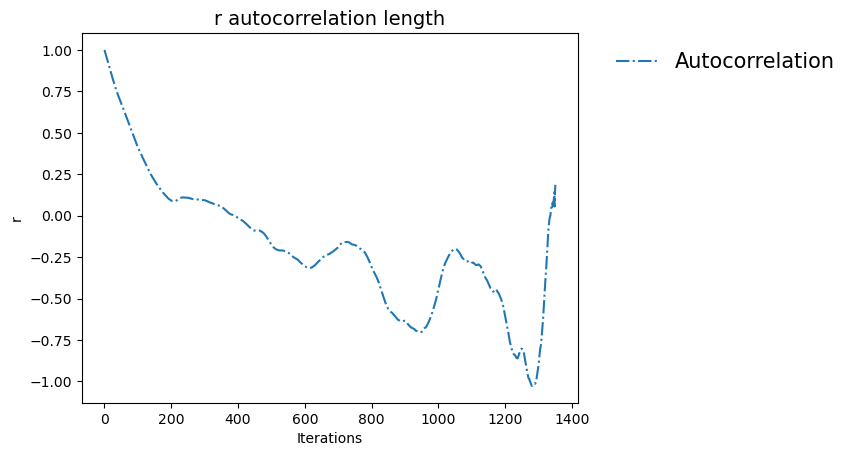

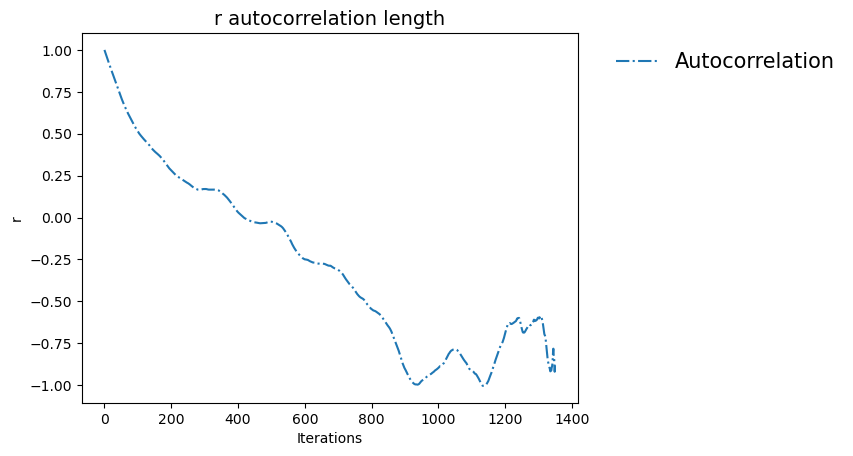

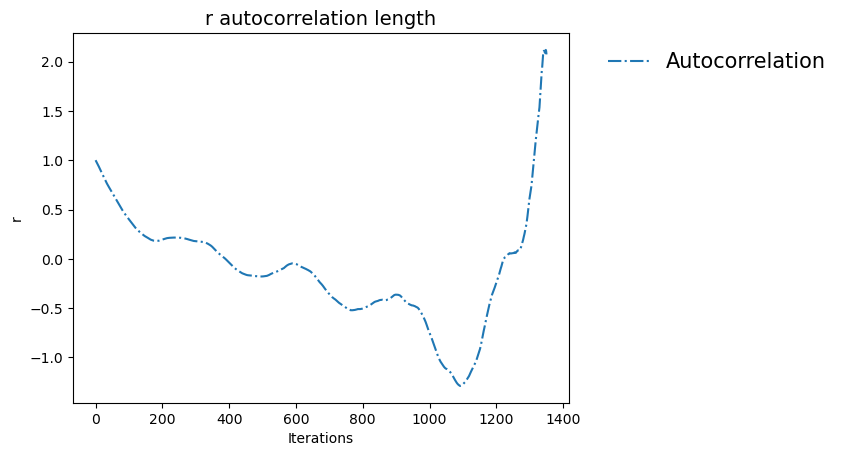

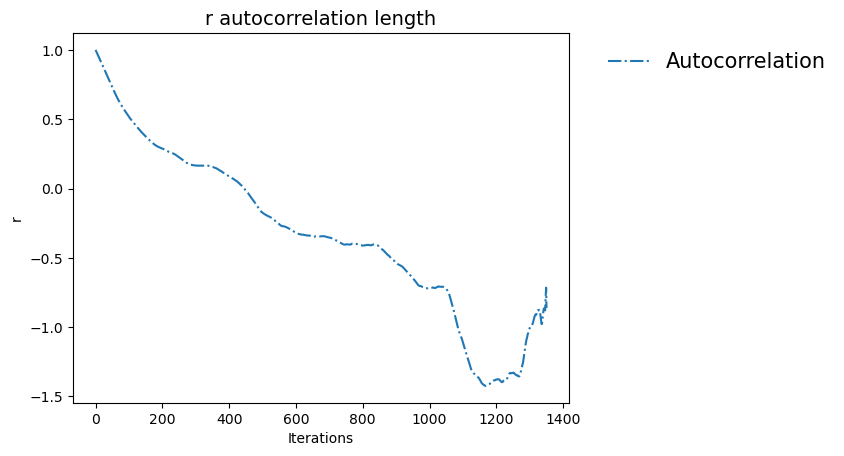

In [668]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        numpyro.diagnostics.print_summary(all_r_samples[job], prob=0.9, group_by_chain=False)
        aucorrelation_r = numpyro.diagnostics.autocorrelation(all_r_samples[job], axis=0)

        plt.figure()
        plt.title('r autocorrelation length', fontsize=14)
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), aucorrelation_r, '-.', label='Autocorrelation')
        plt.xlabel('Iterations')
        plt.ylabel('r')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()


In [669]:
for job in range(num_jobs):
    aucorrelation_B_f = numpyro.diagnostics.autocorrelation(all_params_mixing_matrix_samples[job], axis=0)
    print(aucorrelation_B_f.shape)

(1351, 1)
(1351, 1)
(1351, 1)
(1351, 1)


In [670]:
if MICMAC_sampler_obj.n_components != 1:
    for job in range(num_jobs):
        aucorrelation_B_f = numpyro.diagnostics.autocorrelation(all_params_mixing_matrix_samples[job], axis=0)
        numpyro.diagnostics.print_summary(all_params_mixing_matrix_samples[job], prob=0.9, group_by_chain=False)

        list_correl = ['EE', 'BB', 'EB']

        ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

        frequency_Bf = np.array(instrument['frequency'][1:-1])
        all_B_f_autocorr_synch = aucorrelation_B_f[:,:dim_Bf]
        all_B_f_autocorr_dust = aucorrelation_B_f[:,dim_Bf:]

        frequency_array = np.array(instrument['frequency'])


        if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs < 10:
            plt.figure(figsize=(20,8))
            plt.suptitle(f"Mixing matrix parameters autocorrelation length for {job} over {num_jobs}", fontsize=14)

            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]], label='Exact value')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_synch[:,i], '-.', label='Autocorrelation')
                
                # n_sigma = 3
                # transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
                # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                # mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
                # std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

                # mean_value = all_B_f_sample_synch[:,i].mean()
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

                # plt.yscale('log')
                # plt.xlabel('Iterations')
                # if i == 0:
                #     plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

            # plt.figure(figsize=(20,8))
            # plt.subplot(122)
            for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
                plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
                # plt.subplot(201+len(frequency_Bf)*10+i)
                plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]], label='Exact value')
                plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_dust[:,i], '-.', label='Autocorrelation')

                # n_sigma = 3
                # transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
                # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
                # mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
                # std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

                # mean_value = all_B_f_sample_dust[:,i].mean()
                # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
                # plt.yscale('log')
                plt.xlabel('Iterations')
                if i == 0:
                    plt.ylabel('Amplitude')
            plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            # plt.loglog()

        plt.show()

In [671]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

for job in range(num_jobs):
    # all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:,0]
    # all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,:,1]

    all_B_f_autocorr_synch = aucorrelation_B_f[:,:dim_Bf]
    all_B_f_autocorr_dust = aucorrelation_B_f[:,dim_Bf:]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs >= 10:
        n_columns = 4
        number_rows = (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

        # plt.figure(figsize=(20,8))
        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        fig.suptitle(f"Mixing matrix synch autocorrelation length vs iterations for job {job} over {num_jobs}", fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//n_columns
            num_col = i%n_columns
            ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_synch[:,i], '-.', label='Sample')
            
            # plt.yscale('log')
            # plt.xlabel('Iterations')
            # ax[num_row, num_col].set_xlabel('Iterations')
            if i == 0:
                # plt.ylabel('Amplitude')
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
        useless_plots = number_rows*n_columns - (MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*n_columns)//n_columns
            num_col = (number_rows*n_columns)%n_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


        fig.suptitle(f"Mixing matrix dust autocorrelation length vs iterations for job {job} over {num_jobs}", fontsize=14)
        
        for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//n_columns
            num_col = i%n_columns
            ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_dust[:,i], '-.', label='Sample')

            # plt.yscale('log')
            if i == 0:
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs-n_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

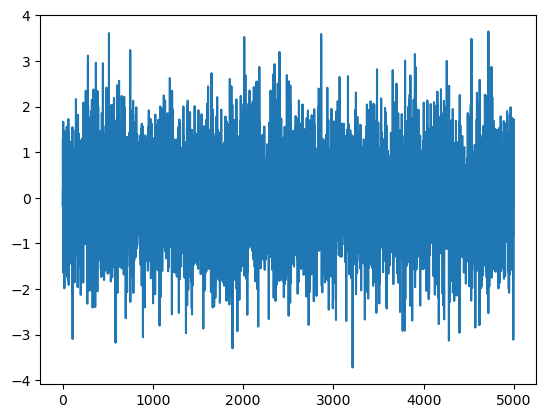

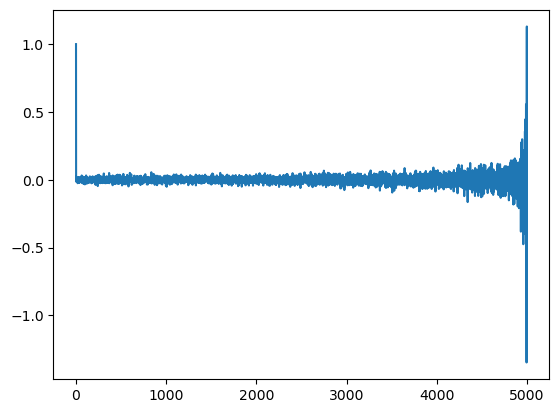

In [672]:
# Test on what to expect for autocorrelation
test_random = np.random.randn(5000)
# test_random = np.ones(1000)
# for i in range(10):
#     test_random[i*100:i*100 + 50] = -1
aucorr_random = numpyro.diagnostics.autocorrelation(test_random, axis=0)

plt.figure()
plt.plot(np.arange(test_random.shape[0]), test_random)
plt.figure()
plt.plot(np.arange(aucorr_random.shape[0]), aucorr_random)
plt.show()

In [673]:
for job in range(num_jobs):
    numpyro.diagnostics.effective_sample_size(jnp.array([all_params_mixing_matrix_samples[job,:]]))

In [674]:
all_r_samples.mean()

0.00796073495712551

In [675]:
all_r_samples.shape

(4, 1351)

In [676]:
micmac.get_Gelman_Rubin_statistics(all_r_samples).mean()

0.9415165398143637

In [677]:
micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples).mean(axis=0)

nan

# Plotting Gelman-Rubin every 100 samples

In [678]:
micmac.get_Gelman_Rubin_statistics(all_r_samples[:,-1000:]).mean(), micmac.get_Gelman_Rubin_statistics(all_r_samples[:,-500:]).mean()

(0.44657087644280663, 0.3627844199890442)

In [679]:
for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    print('Freq', MICMAC_sampler_obj.frequency_array[freq], 'GHz :', micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-1000:, freq]))#.mean(axis=0)

Freq 90 GHz : nan


In [680]:
for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    print('Freq', MICMAC_sampler_obj.frequency_array[freq], 'GHz :', micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-1000:, freq+dim_Bf]))#.mean(axis=0)

Freq 90 GHz : nan


In [681]:
if num_jobs > 1:
    num_GR = 200
    treshold_GR = 0.1

    r_Gelman_Rubin = np.zeros(MICMAC_sampler_obj.number_iterations_sampling+1-num_GR)
    B_f_s_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_GR))
    B_f_d_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_GR))
    for iteration in range(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1):
        r_Gelman_Rubin[iteration-num_GR] = micmac.get_Gelman_Rubin_statistics(all_r_samples[:,-num_GR+iteration:iteration])[0]
        for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            B_f_s_Gelman_Rubin[freq,iteration-num_GR] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-num_GR+iteration:iteration,freq])
            B_f_d_Gelman_Rubin[freq,iteration-num_GR] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,-num_GR+iteration:iteration,freq+dim_Bf])

    frequency_Bf = np.array(instrument['frequency'][1:-1])

    plt.figure(figsize=(14,4))
    plt.title(f"Gelman-Rubin statistics evolution for the last {num_GR} iterations over {num_jobs} jobs", fontsize=14)
    plt.plot(np.arange(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1), r_Gelman_Rubin, label='r')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_s_Gelman_Rubin[freq,:], label=f'B_synch {frequency_Bf[freq]} GHz')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_GR,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_d_Gelman_Rubin[freq,:], label=f'B_dust {frequency_Bf[freq]} GHz')
    
    plt.plot([num_GR,MICMAC_sampler_obj.number_iterations_sampling+1], [treshold_GR,treshold_GR], 'k:', label='Treshold')
    plt.xlabel('Iterations done')
    plt.ylabel('Gelman-Rubin statistics')
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()
        

IndexError: invalid index to scalar variable.

In [ ]:
if num_jobs > 1:
    num_burnin = 00
    treshold_GR = 0.1

    r_Gelman_Rubin = np.zeros(MICMAC_sampler_obj.number_iterations_sampling+1-num_burnin)
    B_f_s_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_burnin))
    B_f_d_Gelman_Rubin = np.zeros((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,MICMAC_sampler_obj.number_iterations_sampling+1-num_burnin))
    for iteration in range(num_burnin+1,MICMAC_sampler_obj.number_iterations_sampling+1):
        r_Gelman_Rubin[iteration-num_burnin-1] = micmac.get_Gelman_Rubin_statistics(all_r_samples[:,num_burnin:iteration])[0]
        for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
            B_f_s_Gelman_Rubin[freq,iteration-num_burnin-1] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,num_burnin:iteration,freq,0])
            B_f_d_Gelman_Rubin[freq,iteration-num_burnin-1] = micmac.get_Gelman_Rubin_statistics(all_params_mixing_matrix_samples[:,num_burnin:iteration,freq,1])

    frequency_Bf = np.array(instrument['frequency'][1:-1])

    plt.figure(figsize=(14,4))
    plt.title(f"Gelman-Rubin statistics evolution from {num_burnin} iterations to the the last over {num_jobs} jobs", fontsize=14)
    plt.plot(np.arange(num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1), r_Gelman_Rubin, label='r')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_s_Gelman_Rubin[freq,:], label=f'B_synch {frequency_Bf[freq]} GHz')
    for freq in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
        plt.plot(np.arange(num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1), B_f_d_Gelman_Rubin[freq,:], label=f'B_dust {frequency_Bf[freq]} GHz')
    
    plt.plot([num_burnin,MICMAC_sampler_obj.number_iterations_sampling+1], [treshold_GR,treshold_GR], 'k:', label='Treshold')
    plt.xlabel('Iterations done')
    plt.ylabel('Gelman-Rubin statistics')
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()
        

In [ ]:
all_params_mixing_matrix_samples[0,-1000:,:].mean(axis=0)

array([0.])

In [ ]:
all_params_mixing_matrix_samples[0,-100:,:].mean(axis=0)

array([0.])

In [ ]:
init_params

Array([], dtype=float64)